In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
DATA_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
INPUT_SIZE = 150

In [3]:
data_dir = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir='',
    extract=True
)

train_dir = os.path.join(os.path.splitext(data_dir)[0], 'train')
val_dir = os.path.join(os.path.splitext(data_dir)[0], 'validation')

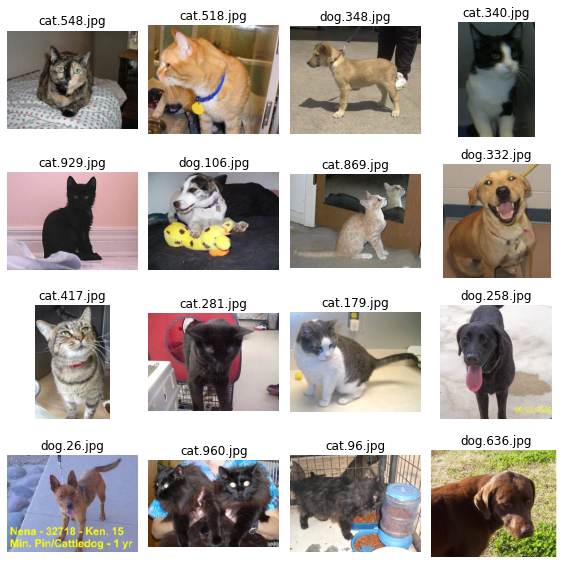

In [4]:
train_files = glob.glob(os.path.join(train_dir, '*/*.jpg'))
picked_files = random.choices(train_files, k=16)

fig = plt.figure(figsize=(8, 8))
for i, image_file in enumerate(picked_files, 1):
    ax = plt.subplot(4, 4, i)
    ax.imshow(load_img(image_file))
    ax.axis('off')
    ax.set_title(os.path.basename(image_file))

plt.tight_layout()
plt.show()

In [5]:
train_data = ImageDataGenerator(rescale=1.0/255)
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_data = ImageDataGenerator(rescale=1.0/255)
val_generator = val_data.flow_from_directory(
    val_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(INPUT_SIZE, INPUT_SIZE, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [8]:
optimizer = keras.optimizers.RMSprop(lr=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/15
63/63 [==============================] - 9s 138ms/step - loss: 0.9985 - accuracy: 0.5415 - val_loss: 0.6756 - val_accuracy: 0.5800
Epoch 2/15
63/63 [==============================] - 9s 139ms/step - loss: 0.6652 - accuracy: 0.6435 - val_loss: 0.6206 - val_accuracy: 0.6410
Epoch 3/15
63/63 [==============================] - 8s 134ms/step - loss: 0.5803 - accuracy: 0.7175 - val_loss: 0.5708 - val_accuracy: 0.7010
Epoch 4/15
63/63 [==============================] - 8s 132ms/step - loss: 0.5102 - accuracy: 0.7475 - val_loss: 0.5974 - val_accuracy: 0.7120
Epoch 5/15
63/63 [==============================] - 8s 132ms/step - loss: 0.4371 - accuracy: 0.8030 - val_loss: 0.5724 - val_accuracy: 0.7180
Epoch 6/15
63/63 [==============================] - 8s 131ms/step - loss: 0.3766 - accuracy: 0.8360 - val_loss: 0.6466 - val_accuracy: 0.7200
Epoch 7/15
63/63 [==============================] - 8s 132ms/step - loss: 0.3154 - accuracy: 0.8660 - val_loss: 0.6418 - val_accuracy: 0.7210
Epoch 

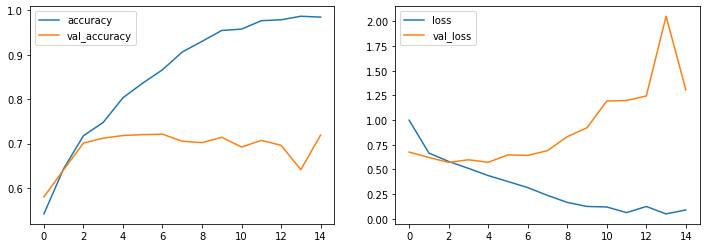

In [10]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [11]:
def read_image_file(image_file):
    img = load_img(image_file, target_size=(INPUT_SIZE, INPUT_SIZE))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

def predict_file(image_file):
    img = read_image_file(image_file)
    classes = model.predict(img)
    if classes[0][0] > 0.5:
        print(f"{image_file} is a dog")
    else:
        print(f"{image_file} is a cat")

In [12]:
val_files = glob.glob(os.path.join(val_dir, '*/*.jpg'))
predict_file(val_files[0])

./cats_and_dogs_filtered/validation/cats/cat.2095.jpg is a dog


In [13]:
# from google.colab import files

# uploaded = files.upload()

# for file in uploaded.keys():
#     predict_file(file)

In [14]:
vis_layers = model.layers[1:6]
vis_outputs = [layer.output for layer in vis_layers]
vis_model = keras.models.Model(inputs=model.input, outputs=vis_outputs)

vis_layer_names = [layer.name for layer in vis_layers]
print(f"vis_layer_names = {vis_layer_names}")

def visualize_image(img):
    vis_feature_maps = vis_model.predict(img)
    for layer_name, feature_map in zip(vis_layer_names, vis_feature_maps):
        num_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * num_features))
        for i in range(num_features):
            x = feature_map[0, :, :, i]
            if x.sum() == 0:
                continue
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / num_features
        plt.figure(figsize=(scale * num_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

vis_layer_names = ['max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2']


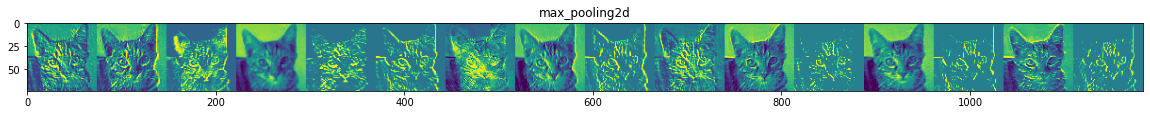

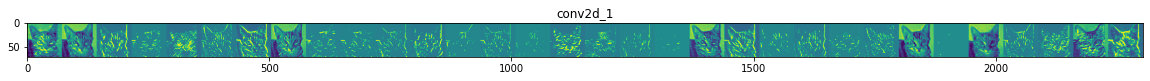

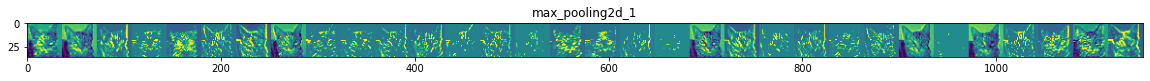

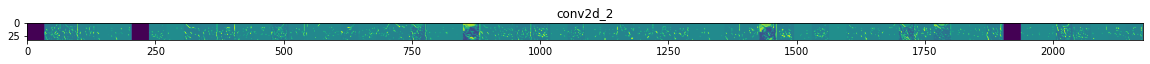

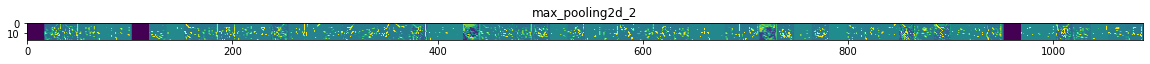

In [15]:
image = read_image_file(val_files[0])
visualize_image(image)